<a href="https://colab.research.google.com/github/cedricsoares/openclassrooms-classez-des-images-l-aide-d-algorithmes-de-deep-learning/blob/master/P6_01_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer vision : comparaison entrainement modèle construit avec le transfer learning

Ce notebook met en oeuvre la comparaison entres des modèles de computer vision entrainement entraînés initialement et l'utilisation de transfer learning. 

La démarche a été réalisée de manière itérative par entraînements sucessifs de "nouveaux modèles":


1.   Modèle initial avec préprocessing seul
2.   Ajout d'optimisations : dropout, batchnormalization ...
3.   Implémentation de la data augmentation 
4.  Transfer learning avec optimisation et data augmentation 

Ces quatres étapes ont été réalisée sur la base d'un modèle VGG16 : 

*  Reconstitué par empilement de couches pour les trois premières étapes
*  Modèle pré-entrainé sur ImageNet pour la quatrième

Nous avons enfin comparé les performances d'un modèle VGG16 pré-entrainé avec RESNET50 et Xception.

L'ensemble des travaux ont été menés à l'aide du dataset [Stanford Dogs](http://vision.stanford.edu/aditya86/ImageNetDogs/). Ce dernier est constitué de 20 580 images de chiens triées en 120 classes relatives à leur race. 

Les entrainements ont été réalisés sur GPU à l'aide de Google Colab.

Le meileur modèle a été par la suite intégré dans un démonstrarteur développé à l'aide du framework [Streamlit](https://streamlit.io).







## Import des données 

Nous commençons par importer les données sur le site du laboratoire de computer vision de Stanford. Les photos sont pré-classées par races de chiens mais sans partition.

Nous réalisons donc une partition de la manière suivante:


*   Train: 75%
*   Validation: 15%
*   Test: 10%  



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time

import os, shutil, tarfile, requests

%tensorflow_version 2.x
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorboard import notebook
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

VM_ROOT_DIR = '/content'
PROJECT_ROOT_DIR = '/content/drive/MyDrive/Formations/Openclassrooms/Projet 6'
DATA_PATH = os.path.join(VM_ROOT_DIR, "data")
os.makedirs(DATA_PATH, exist_ok=True)

url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar'
if url.find('/'):
  fname = url.rsplit('/', 1)[1]

r = requests.get(url, allow_redirects=True)
open(fname, 'wb').write(r.content)
print("...Archive downloaded...")


src = os.path.join(VM_ROOT_DIR, fname)
dest = os.path.join(DATA_PATH, fname)
shutil.move(src, dest)

with tarfile.open(dest, 'r') as f:
  f.extractall(DATA_PATH)

print("...Archive extracted...")

IMAGES_PATH = os.path.join(DATA_PATH, "Images")

TRAIN_PATH = os.path.join(DATA_PATH, "train")
os.makedirs(TRAIN_PATH, exist_ok=True)

VAL_PATH = os.path.join(DATA_PATH, "val")
os.makedirs(VAL_PATH, exist_ok=True)

TEST_PATH = os.path.join(DATA_PATH, "test")
os.makedirs(TEST_PATH, exist_ok=True)

val_threshold = 0.75
test_threshold = val_threshold + 0.15

train_size = 0
val_size = 0
test_size = 0
num_classes = 0

for breed_dir in os.listdir(IMAGES_PATH):
  num_classes += 1
  breed_dir_path = os.path.join(IMAGES_PATH, breed_dir)
  breed_train_path = os.path.join(TRAIN_PATH, breed_dir)
  breed_val_path = os.path.join(VAL_PATH, breed_dir)
  breed_test_path = os.path.join(TEST_PATH, breed_dir)
  os.makedirs(breed_train_path, exist_ok=True)
  os.makedirs(breed_val_path, exist_ok=True)
  os.makedirs(breed_test_path, exist_ok=True)
  breed_list = os.listdir(breed_dir_path)
  breed_size = len(breed_list)
  breed_val_threshold = math.ceil(breed_size *  val_threshold)
  breed_test_threshold = math.ceil(breed_size * test_threshold)
  breed_train_range = breed_list[:breed_val_threshold]
  breed_val_range = breed_list[breed_val_threshold:breed_test_threshold]
  breed_test_range = breed_list[breed_test_threshold:breed_size]

  try:
    assert len(breed_train_range) + len(breed_val_range) + len(breed_test_range) == breed_size
  except AssertionError :
    print("Toutes les photos de la race ne sont pas prise en compte")
    print(f"Pour la race {breed_dir}")
    break

  for i, image in enumerate(breed_train_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_train_path, image)
    shutil.copyfile(src, dest)
    train_size += 1

  for _, image in enumerate(breed_val_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_val_path, image)
    shutil.copyfile(src, dest)
    val_size +=1

  for _, image in enumerate(breed_test_range):
    src = os.path.join(breed_dir_path, image)
    dest = os.path.join(breed_test_path, image)
    shutil.copyfile(src, dest)
    test_size +=1
  
print("... Data split done ...")
print(f"Nombre de classes: {num_classes}")
print(f"train set size: {train_size}")
print(f"val set size: {val_size}")
print(f"test set size: {test_size}")

...Archive downloaded...
...Archive extracted...
... Data split done ...
Nombre de classes: 120
train set size: 15480
val set size: 3091
test set size: 2009
CPU times: user 10.4 s, sys: 10.3 s, total: 20.7 s
Wall time: 1min 1s


## Entrainement VGG16 réconstitué

### Construction des générateurs pour le préprocessing

---



Pour les besoin de l'entrainement du modèle , nous construisons des générateurs afin de réaliser le préprocessing et livrer les images par batch au modèle. Pour le préprocessing nous implémentons une redimenssions des images en 224 x 224 et une normalisation des valeurs des pixels entre 0 et 1.



In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode="categorical")

val_generator = datagen.flow_from_directory(VAL_PATH,
                                          target_size=(224,224),
                                          batch_size=32,
                                          class_mode='categorical')

Found 15480 images belonging to 120 classes.
Found 3091 images belonging to 120 classes.


### Construction d'une architecture type VGG16

À l'aide de l'API Keras nous réconstituons l'architecture de VGG16.

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

DefaultMaxPooling = partial(keras.layers.MaxPooling2D,
                 pool_size=(2,2), strides=(2,2))

model = keras.models.Sequential([
        DefaultConv2D(filters=64, input_shape=[224,224,3]),
        DefaultConv2D(filters=64),
        DefaultMaxPooling(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        DefaultMaxPooling(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

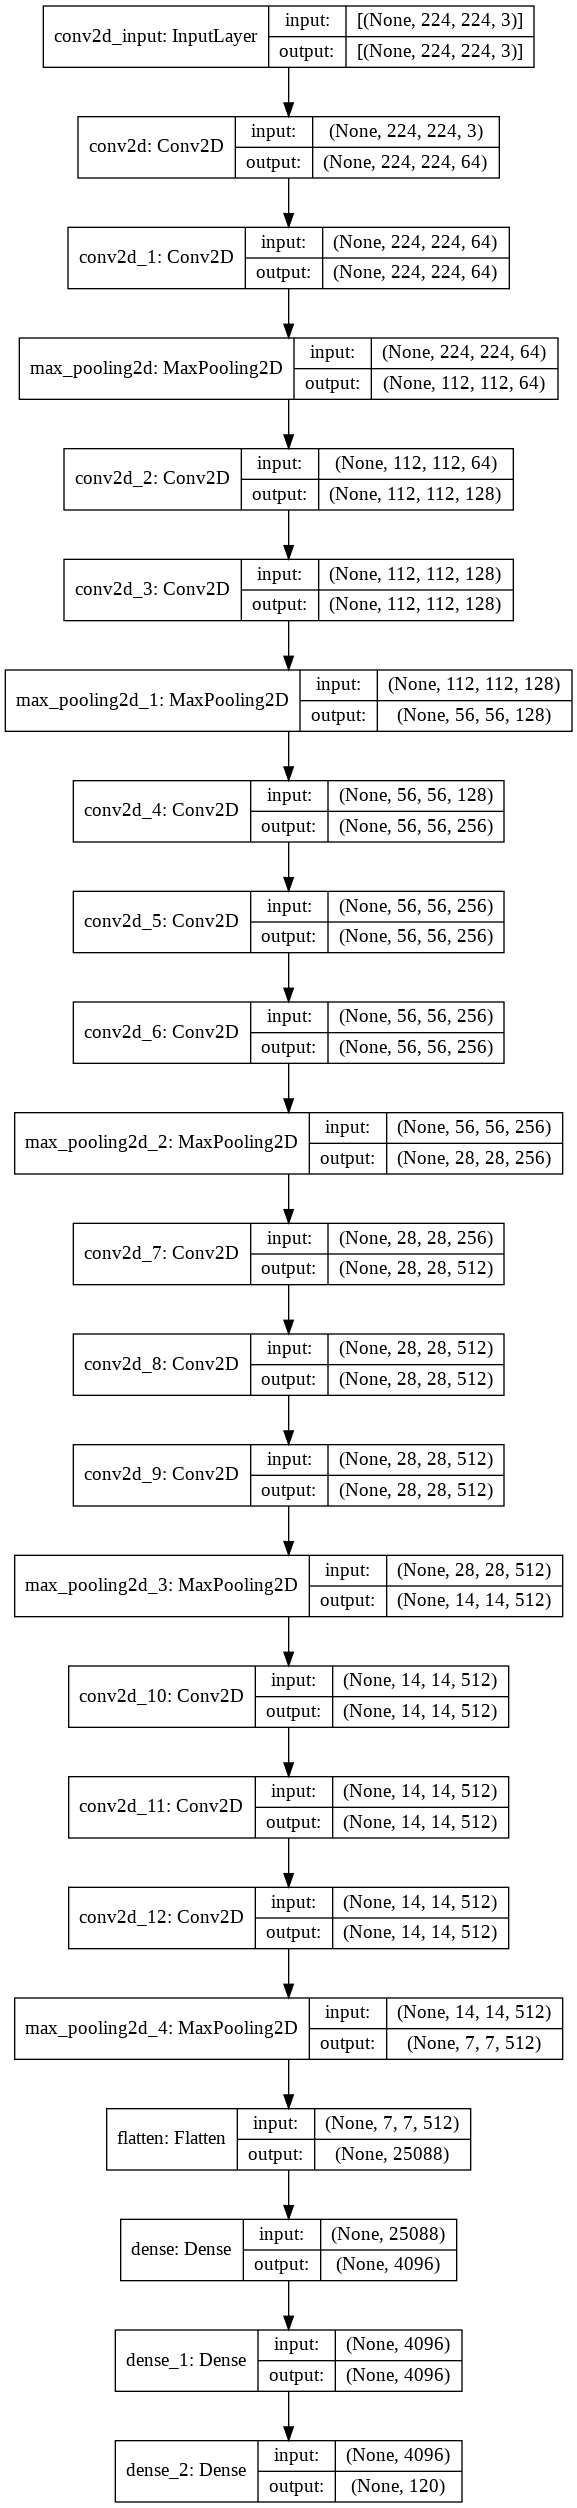

In [ ]:
FIGS_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/my_vgg16_model.png", show_shapes=True)

### Définition des callsbacks 



Pour le premier entrainement nous ne définissons deux callback. 


*   Le premier va sauvegarder le modèle à la fin de chaque epoch si l'accuracy de validation de ce dernier est meilleure que lors de l'epoch précédente.


*   Le second va afficher la progression de la fonction de coût et l'accuracy sur les jeux d'entrainment et de validation. Pour ce callback nous avons préféré livelossplot à Tensorboard. En effet les résultats de la solution de Tensorflow ne sont pas visibles dans des notebooks sauvegardés en ligne.



#### Checkpoint de sauvegarde

In [ ]:
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODELS_PATH, exist_ok=True)
FILE_PATH = MODELS_PATH + "/my_vgg_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

## Affichage des courbes

In [ ]:
!pip install livelossplot

In [ ]:
from livelossplot import PlotLossesKeras
plot_loss_cb = PlotLossesKeras()

### Entrainement du modèle

L'entrainment va être réalisé sur 100 epochs avec des batchs de 32 images. Les ImageDataGenerator de Keras étant des itérateurs, il est nécessaire de passer des paramètres (steps_per_epoch et validation_steps) pour limiter le nombre limiter le nombre d'itérations. 

Pour ce premier entrâinement nous avons testé l'optimizer le plus basique possible: la descentre de gradients simple.

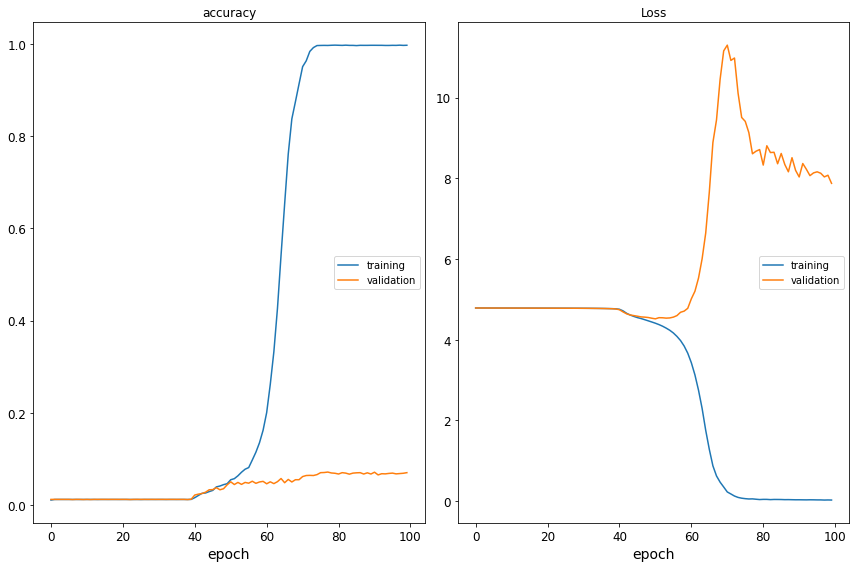

accuracy
	training         	 (min:    0.011, max:    0.997, cur:    0.997)
	validation       	 (min:    0.012, max:    0.072, cur:    0.070)
Loss
	training         	 (min:    0.027, max:    4.787, cur:    0.027)
	validation       	 (min:    4.519, max:   11.302, cur:    7.877)
CPU times: user 3h 55min 23s, sys: 5min 29s, total: 4h 53s
Wall time: 3h 7min 35s


In [ ]:
%%time

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])

batch_size = 32
epochs = 100

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb, plot_loss_cb])

En observant les coubres nous constatons que le modèle n'a quasiment pas appris sur les 40 premières epoch puis s'est mis à surajuster sur le jeu d'entrainement à partir de la 60ème epoch.

### Évaluation du modème

In [ ]:
test_generator = datagen.flow_from_directory(TEST_PATH,
                                            target_size=(224,224),
                                            batch_size=32,
                                            class_mode='categorical')

results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")


Found 2009 images belonging to 120 classes.
62/62 [==============================] - 7s 107ms/step - loss: 7.9030 - accuracy: 0.0610
test loss, test acc: [7.902954578399658, 0.06098790466785431]


L'évaluation du modèle confirme que le modèle généralise très mal sur les données de test.

## Entrainement avec optimisations

Afin d'essayer d'améliorer les performance d'un modèle VGG16 initial nous ajoutons:



*   Ajout de batch normalization et de dropout avant chaque couche totalement connectée.  Le premier élément garantie un modèle plus stable et potentiellement convergeant plus vite. Le second permet d'éviter le surajustement.

*  Ajout d'un callback d'early stopping stoppant l'entrainement du modèle si fonction de coût ne minimise plus sur le jeu de validation pendant 10 épochs. 

*  Remplacement de l'optimizer descente de gradient par une RMSprop afin de permettre au modèle de converger plus vite. 



In [ ]:
%%time

from functools import partial

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

DefaultMaxPooling = partial(keras.layers.MaxPooling2D,
                 pool_size=(2,2), strides=(2,2))

model = keras.models.Sequential([
        DefaultConv2D(filters=64, input_shape=[224,224,3]),
        DefaultConv2D(filters=64),
        DefaultMaxPooling(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        DefaultMaxPooling(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

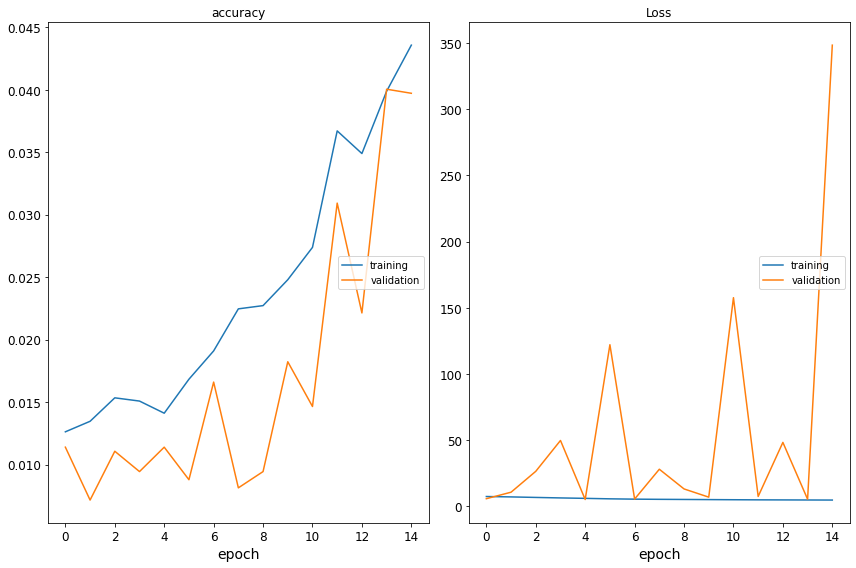

accuracy
	training         	 (min:    0.013, max:    0.044, cur:    0.044)
	validation       	 (min:    0.007, max:    0.040, cur:    0.040)
Loss
	training         	 (min:    4.510, max:    7.185, cur:    4.510)
	validation       	 (min:    4.932, max:  348.588, cur:  348.588)
Epoch 00015: early stopping
CPU times: user 41min 11s, sys: 1min 7s, total: 42min 18s
Wall time: 31min 30s


In [ ]:
%%time

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras


MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
os.makedirs(MODELS_PATH, exist_ok=True)
FILE_PATH = MODELS_PATH + "/my_vgg_model_optimized.h5"

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(TRAIN_PATH,
                                              target_size=(224,224),
                                              batch_size=32,
                                              class_mode="categorical")

val_generator = datagen.flow_from_directory(VAL_PATH,
                                          target_size=(224,224),
                                          batch_size=32,
                                          class_mode='categorical')

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop",
              metrics=["accuracy"])

batch_size = 32
epochs = 100

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

Nous pouvons voir que le modèle s'est arrêté au bout de 15 epochs. En effet malgré une amélioration de l'accuracy de la fonction de coût sur le jeu de validation ne minimisait plus depuis 10 epochs.

### Évaluation du modèle

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 8s 126ms/step - loss: 4.9389 - accuracy: 0.0116
test loss, test acc: [4.938889503479004, 0.011592742055654526]


Sur le laps de temps d'entraînement, nous constatons que le modèle n'a quasiment pas appris. 

## Data augmentation

Le nombre d'images d'entraînement étant relativement faible (150 à 200 photos de chiens par classes) nous avons artificiellement démuliplié les images vues par le modèle, sans en augmenter le nombre, en implémentant de la data augmentation. 

Ci-dessous. Nous avons testé différents types de transformations avant des combiner : 


*   Rotation
*   Width shift range (décalage horizontal)
*   Height shift range (décalage vertical)
*   Shear range (cisaillement)
*   Zoom range
*   Horizontal flip (retournement horizontal)
*   Channel shift (modification dd l'intensité sur les cannaux RVB)



### Rotation

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

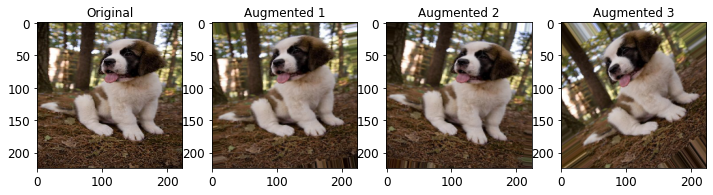

In [ ]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


directory = TRAIN_PATH
test_dir_path = os.path.join(TRAIN_PATH, "n02109525-Saint_Bernard")


def visualize(original, augmented):

  fig = plt.figure(figsize=(12,12))
  plt.subplot(1,4,1)
  plt.title('Original')
  plt.imshow(original)

  for i in range(3):
    plt.subplot(1,4,i+2)
    plt.title(f'Augmented {i+1}')
    plt.imshow(augmented[i])
 
def test_image_generator(datagen):
  
  fnames = [os.path.join(test_dir_path, fname) for 
            fname in os.listdir(test_dir_path)]

  img_path = fnames[3]
  img = image.load_img(img_path, target_size=(224,224))
  x = image.img_to_array(img)
  x = x.reshape((1,) + x.shape)
  augmented = []

  i = 0
  for batch in datagen.flow(x, batch_size = 1):
    plt.figure(i)
    augmented.append(image.array_to_img(batch[0]))
    i += 1
    if i % 3 == 0:
      break

  visualize(img, augmented)


datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=40,
                            fill_mode='nearest')

test_image_generator(datagen=datagen)


### Width shift range

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

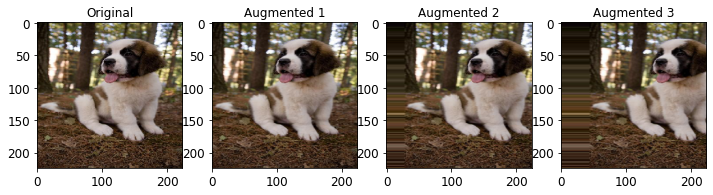

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                            width_shift_range=0.2,
                            fill_mode='nearest')

test_image_generator(datagen=datagen)

### Height shift range

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

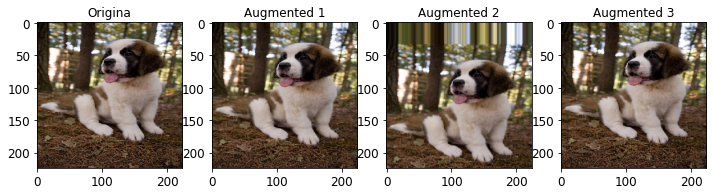

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                            height_shift_range=0.2,
                            fill_mode='nearest')

test_image_generator(datagen=datagen)

### Shear Range

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

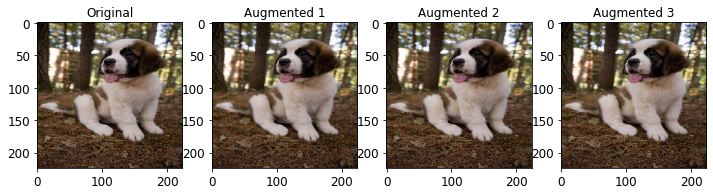

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                            shear_range=0.2,
                            fill_mode='nearest')

test_image_generator(datagen=datagen)

### Zoom range

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

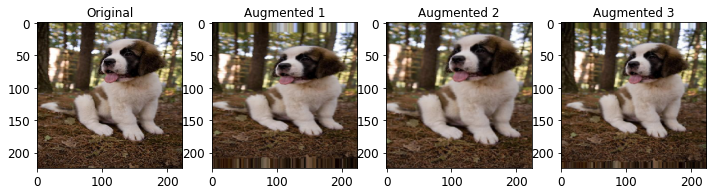

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                            zoom_range=0.2,
                            fill_mode='nearest')

test_image_generator(datagen=datagen)

### Horizontal flip

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

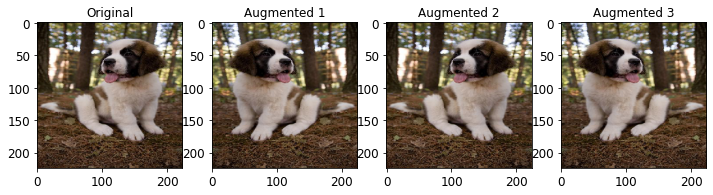

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                            horizontal_flip=True,
                            fill_mode='nearest')

test_image_generator(datagen=datagen)

### Channel shift

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

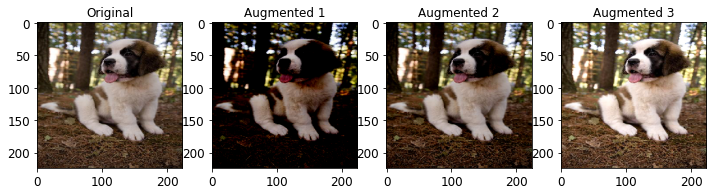

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                                  channel_shift_range=100,
                                  )

test_image_generator(datagen=datagen)

### combinaison des transformations

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

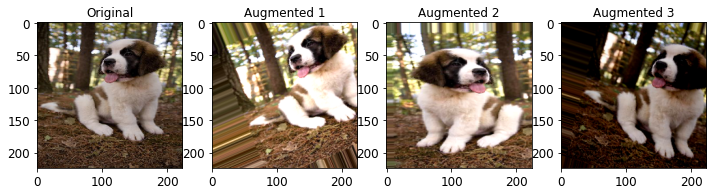

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=100,
                                  horizontal_flip=True,
                                  )

test_image_generator(datagen=datagen)

## Entrainement du model 

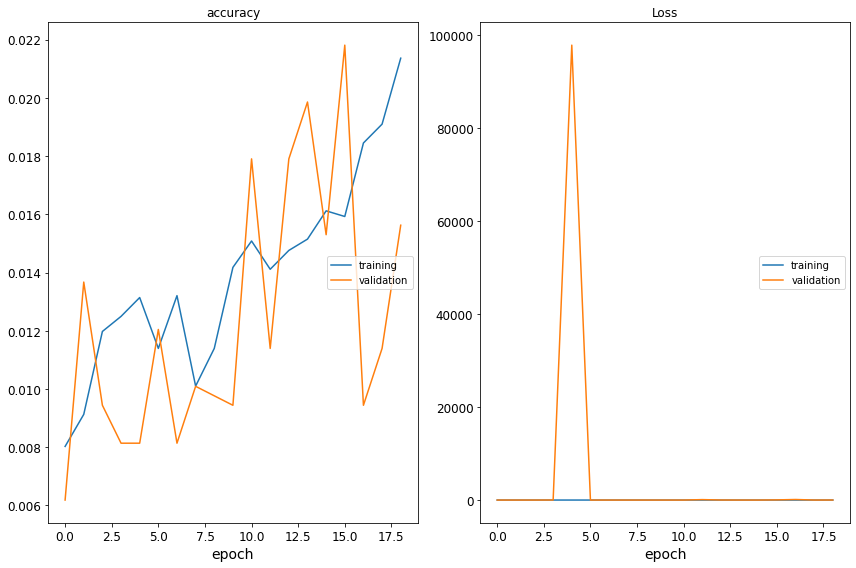

accuracy
	training         	 (min:    0.008, max:    0.021, cur:    0.021)
	validation       	 (min:    0.006, max:    0.022, cur:    0.016)
Loss
	training         	 (min:    4.789, max:    7.199, cur:    4.789)
	validation       	 (min:    4.827, max: 97815.750, cur:   13.688)
CPU times: user 1h 45min 16s, sys: 1min 34s, total: 1h 46min 51s
Wall time: 1h 18min 3s


In [ ]:
%%time

from functools import partial
from livelossplot import PlotLossesKeras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
        DefaultConv2D(filters=64, input_shape=[224,224,3]),
        DefaultConv2D(filters=64),
        DefaultMaxPooling(),
        DefaultConv2D(filters=128),
        DefaultConv2D(filters=128),
        DefaultMaxPooling(),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultConv2D(filters=256),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultConv2D(filters=512),
        DefaultMaxPooling(),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(num_classes, activation = 'softmax')
])


batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(rescale=1./255)


val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop",
              metrics=["accuracy"])


FILE_PATH = MODELS_PATH + "/my_vgg_model_data_augmented.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_loss',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='min')

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  restore_best_weights=True)

plot_loss_cb = PlotLossesKeras()

epochs = 100

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

## Évaluation du modèle

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')


results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 8s 128ms/step - loss: 4.8304 - accuracy: 0.0096
test loss, test acc: [4.830376148223877, 0.009576613083481789]


Même après data augmentation le modèle n'apprend toujours pas.

## Transfert learning



Nous décidons donc pour le prochain entrainement d'utiliser un modèle VGG16 pré-entrainé sur ImageNet. Le dataset Stanford Dog étant issu d'ImageNet, nous pouvons considérer que les features relatives au chien ont été apprises lors du pré-entrainement. Nous gelons donc les couches convolutives du modèle. 

Il est par contre nécessaire de modifier les couches totalement connectées notamment à cause de la différence de dimensions des problèmes. En effet ImageNet comporte 1000 classes alors que Stanford Dogs n'en comporte que 120.

A l'image des des entraînement précédents, nous ajoutons une bachnormalization et un dropout (50%) avant chaque couche totalement connectée.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)


from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
num_classes = 120
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(4096, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

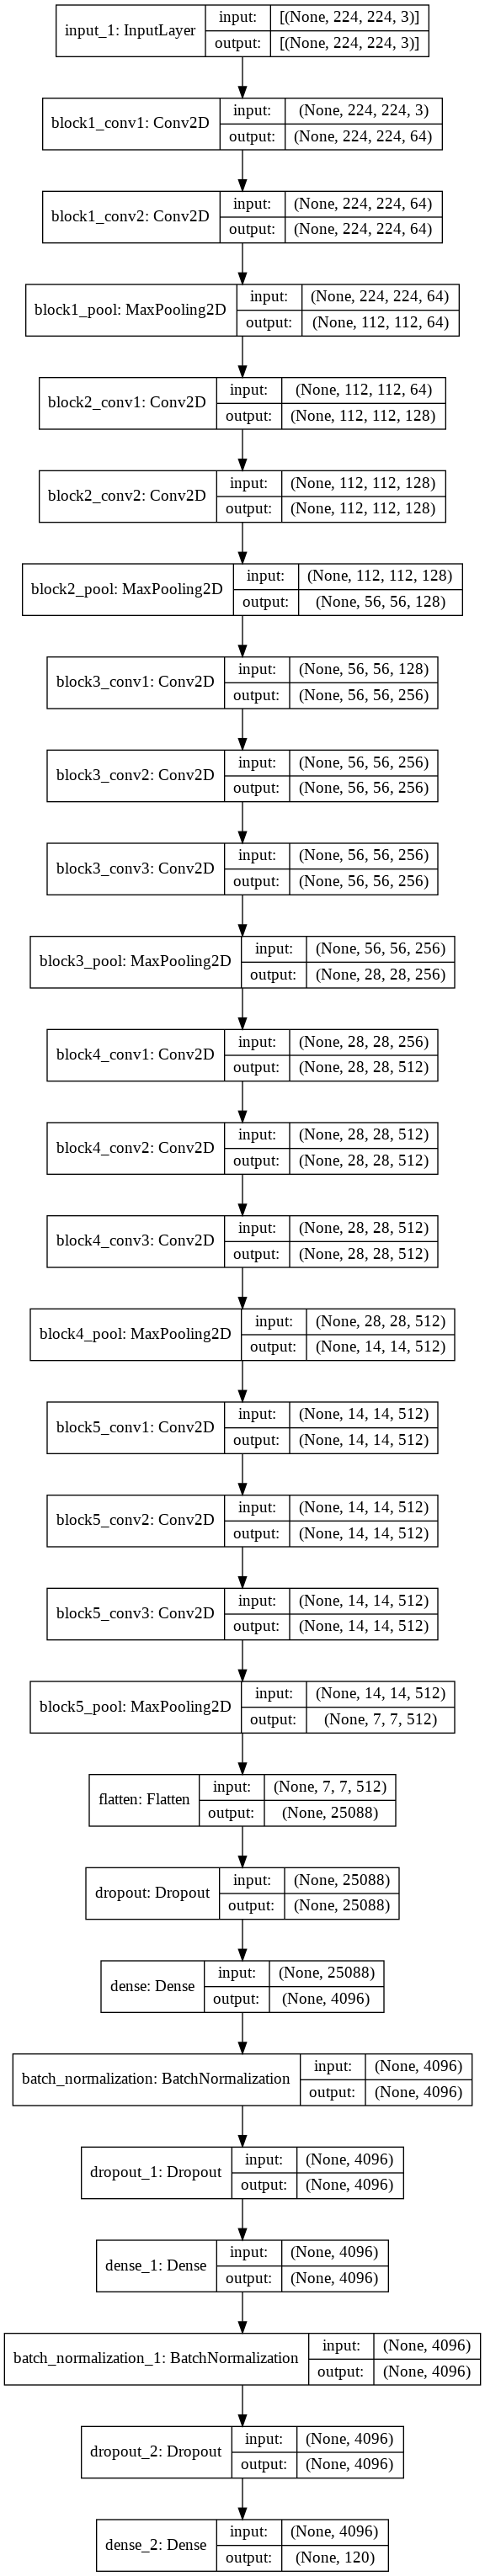

In [ ]:
FIGS_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/transfer_vgg16_model.png", show_shapes=True)

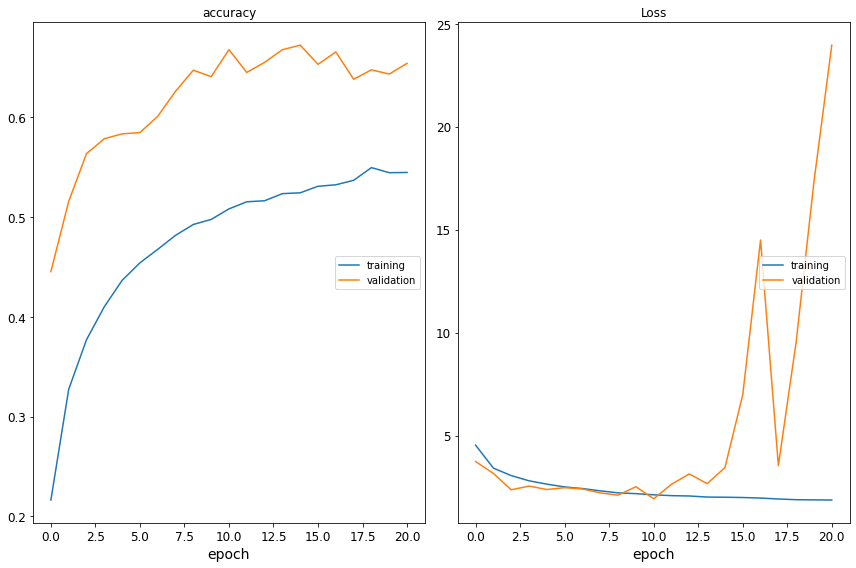

accuracy
	training         	 (min:    0.216, max:    0.550, cur:    0.545)
	validation       	 (min:    0.445, max:    0.672, cur:    0.654)
Loss
	training         	 (min:    1.873, max:    4.538, cur:    1.873)
	validation       	 (min:    1.934, max:   23.959, cur:   23.959)
Epoch 00021: early stopping
CPU times: user 1h 30min 40s, sys: 1min 35s, total: 1h 32min 15s
Wall time: 1h 25min 46s


In [ ]:
%%time 

import os

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

IMAGES_PATH = os.path.join(DATA_PATH, "Images")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val")
TEST_PATH = os.path.join(DATA_PATH, "test")

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

model.compile(loss="categorical_crossentropy", 
              optimizer="rmsprop", 
              metrics=["accuracy"])

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
FILE_PATH = MODELS_PATH + "/transfert_vgg_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')


early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 100

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

En observant les courbes nous constatons une accuracy sur le jeu de validation supérieure à 40% dès première epoch. Elle peuvent par contre sous-entendre que le modèle aurait tendance à sous-ajuster lorsqu'il a été arrêté. Vérifions en évaluant le modèle sur le jeu de test.

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 9s 142ms/step - loss: 2.0963 - accuracy: 0.6542
test loss, test acc: [2.0963361263275146, 0.6542338728904724]


In fine modèle a une accuracy comparable entre le jeu de validation et le jeu de test. Par contre avec 65,42% nous souhaitons vérifier si d'autres modèles pré-entrainer pourraient offrir de meilleures performances. Nous sauvegardons tout de même les poids du modèle VGG16.

In [ ]:
WEIGHTS_PATH = MODELS_PATH + "/transfert_vgg_weights.ckpt"

model.save(FILE_PATH)
model.save_weights(WEIGHTS_PATH)

## Maximisation de la performance en changeant de modèle

### ResNet50

Nous commençons par ResNet. La démarche de transfer learning et les optimisations restent les mêmes.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input



base_model = ResNet50(include_top=False,
                  input_shape = (224,224,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
num_classes = 120
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation = 'softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

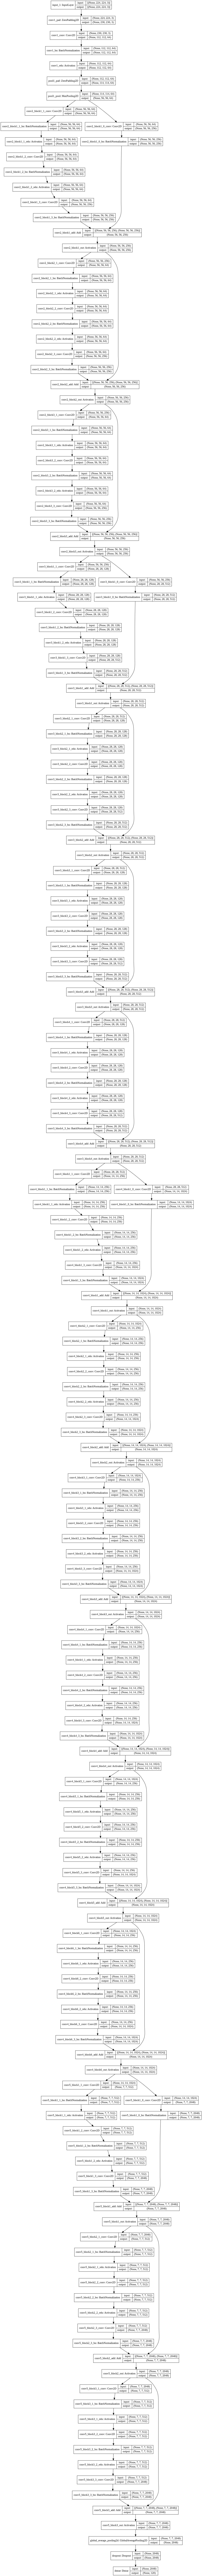

In [ ]:
FIGS_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/transfer_resnet50_model.png", show_shapes=True)

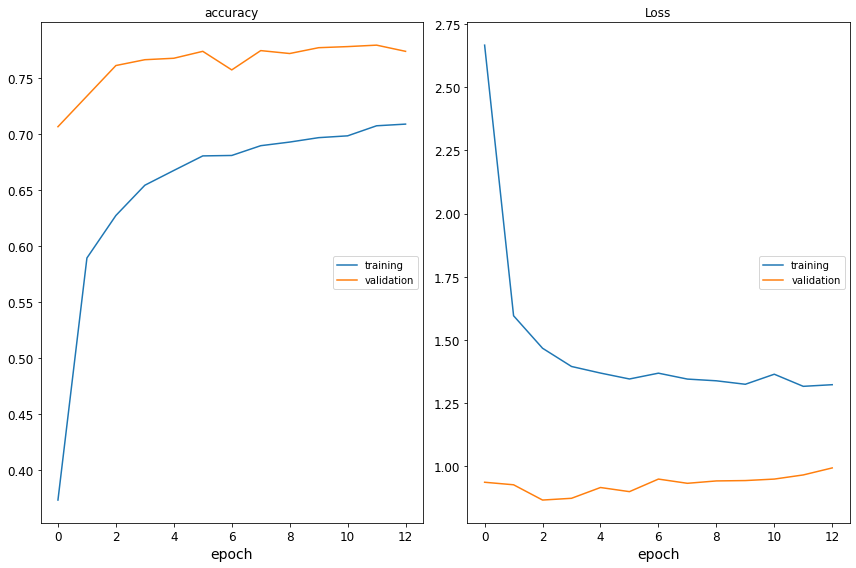

accuracy
	training         	 (min:    0.373, max:    0.709, cur:    0.709)
	validation       	 (min:    0.707, max:    0.780, cur:    0.774)
Loss
	training         	 (min:    1.316, max:    2.667, cur:    1.322)
	validation       	 (min:    0.866, max:    0.993, cur:    0.993)
Epoch 00013: early stopping
CPU times: user 55min 44s, sys: 1min 1s, total: 56min 46s
Wall time: 53min 56s


In [ ]:
%%time 

import os

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

IMAGES_PATH = os.path.join(DATA_PATH, "Images")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val")
TEST_PATH = os.path.join(DATA_PATH, "test")

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(224,224),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                          target_size=(224,224),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

model.compile(loss="categorical_crossentropy", 
              optimizer='rmsprop', 
              metrics=["accuracy"])

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
FILE_PATH = MODELS_PATH + "/transfert_resnet50_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 100

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  shuffle=False,
                                                  target_size=(224,224),
                                                  batch_size=32,
                                                  class_mode='categorical')

results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 9s 143ms/step - loss: 0.9105 - accuracy: 0.7485
test loss, test acc: [0.910485029220581, 0.7484878897666931]


Nous constatons un un apprentissage plus rapide et une accuracy sensiblement supérieure.

In [ ]:
WEIGHTS_PATH = MODELS_PATH + "/transfert_resnet50_weights.ckpt"

model.save(FILE_PATH)
model.save_weights(WEIGHTS_PATH)

### Xception

Nous testons à présent le modèle Xception afin de voir s'il est encore possible d'optemir une meilleur accuracy.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

from tensorflow.keras.applications.xception import Xception, preprocess_input



base_model = Xception(include_top=False,
                  input_shape = (299,299,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

base_model.summary()

83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________

In [ ]:
num_classes = 120
x = keras.layers.BatchNormalization()(base_model.output)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(1024, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
predictions = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs=base_model.input, outputs=predictions)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

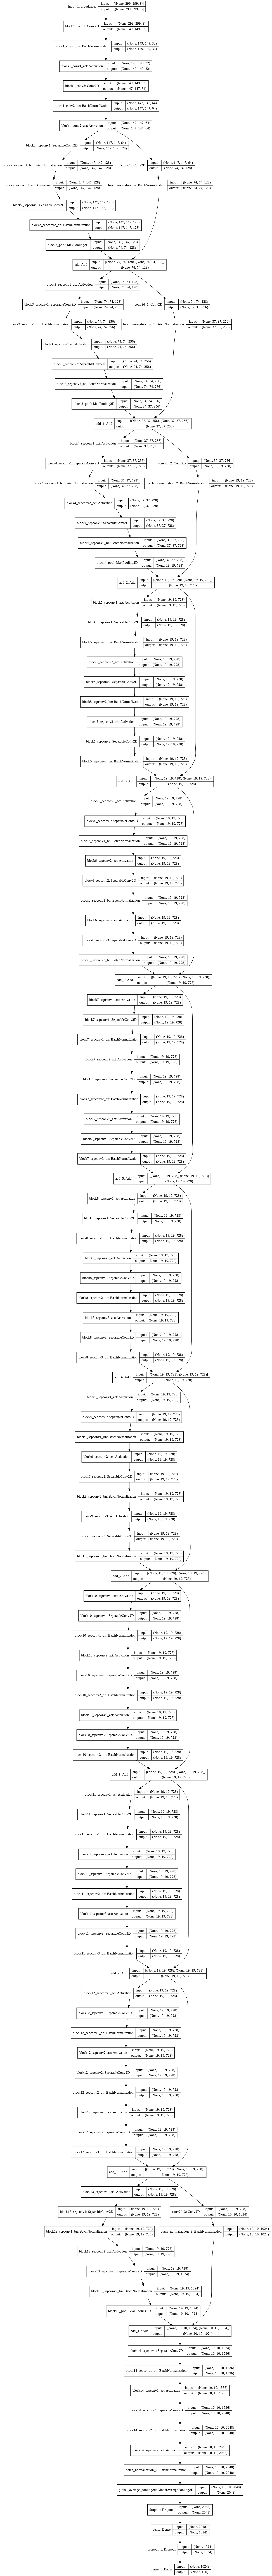

In [ ]:
FIGS_PATH = os.path.join(PROJECT_ROOT_DIR, "figures")
os.makedirs(FIGS_PATH, exist_ok=True)
keras.utils.plot_model(model, FIGS_PATH + "/transfer_xception_model.png", show_shapes=True)

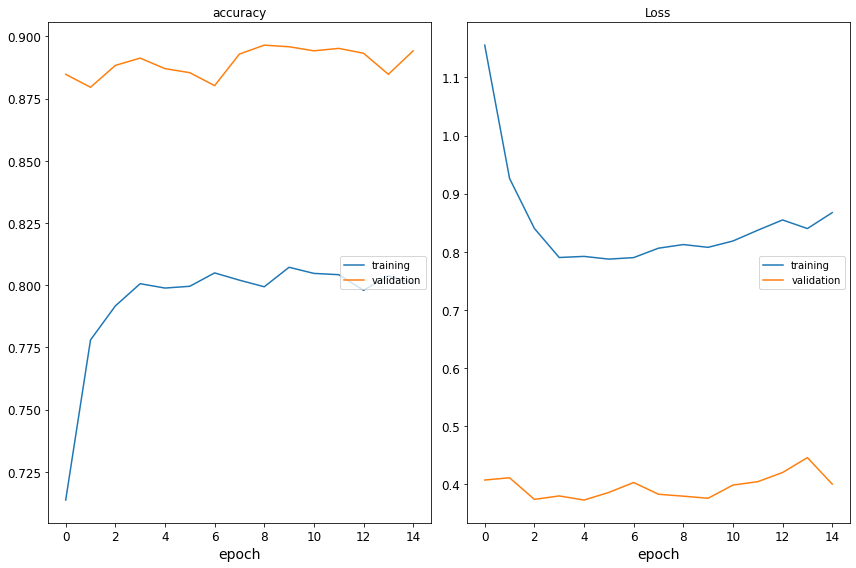

accuracy
	training         	 (min:    0.714, max:    0.807, cur:    0.801)
	validation       	 (min:    0.880, max:    0.896, cur:    0.894)
Loss
	training         	 (min:    0.787, max:    1.156, cur:    0.867)
	validation       	 (min:    0.373, max:    0.446, cur:    0.400)
Epoch 00015: early stopping
CPU times: user 1h 26min 1s, sys: 1min 8s, total: 1h 27min 10s
Wall time: 1h 21min 55s


In [ ]:
%%time 

import os

from keras.preprocessing.image import ImageDataGenerator
from livelossplot import PlotLossesKeras

IMAGES_PATH = os.path.join(DATA_PATH, "Images")
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "val")
TEST_PATH = os.path.join(DATA_PATH, "test")

batch_size = 32

train_datagen = ImageDataGenerator(rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  channel_shift_range=20,
                                  horizontal_flip=True,
                                  preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_PATH,
                                                    target_size=(299,299),
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    class_mode="categorical")


val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


val_generator = val_datagen.flow_from_directory(VAL_PATH,
                                          target_size=(299,299),
                                          shuffle=False,
                                          batch_size=batch_size,
                                          class_mode='categorical')

model.compile(loss="categorical_crossentropy", 
              optimizer='rmsprop', 
              metrics=["accuracy"])

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
FILE_PATH = MODELS_PATH + "/transfert_xception_model.h5"

checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=FILE_PATH,
                                                monitor='val_accuracy',
                                                verbose=1,
                                                save_best_only=True,
                                                mode='max')

early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=10,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True)
plot_loss_cb = PlotLossesKeras()


epochs = 100

history = model.fit(
                train_generator,
                steps_per_epoch = train_size // batch_size,
                epochs=epochs,
                validation_data=val_generator,
                validation_steps = val_size // batch_size,
                callbacks=[checkpoint_cb,
                           early_stopping_cb,
                           plot_loss_cb])

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(TEST_PATH,
                                                  shuffle=False,
                                                  target_size=(299,299),
                                                  batch_size=32,
                                                  class_mode='categorical')

results = model.evaluate(test_generator, steps=test_size // batch_size)
print(f"test loss, test acc: {results}")

Found 2009 images belonging to 120 classes.
62/62 [==============================] - 9s 141ms/step - loss: 0.3787 - accuracy: 0.8896
test loss, test acc: [0.37867721915245056, 0.8896169066429138]


Les performances sont encore meilleure avec une augmentation de l'accuracy de l'ordre de 15 points. 

In [ ]:
WEIGHTS_PATH = MODELS_PATH + "/transfert_xception_weights.ckpt"

model.save(FILE_PATH)
model.save_weights(WEIGHTS_PATH)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


## Prédiction

Nous terminons par la construction d'une fonction de prédiction. Cette dernière retourne la classe ayant la probabilitée d'appartenance la plus élevé. 

Label prédit: Blenheim_spaniel


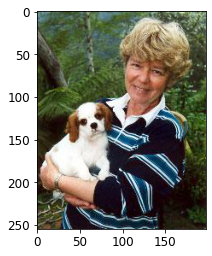

In [ ]:
from  keras.preprocessing import image
from keras.applications.xception import preprocess_input, decode_predictions
from PIL import Image

MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
FILE_PATH = MODELS_PATH + "/transfer_Xception_model.h5"

class_names = []
for breed in sorted(os.listdir(IMAGES_PATH)):
  splitted_breed = breed.split('-')
  if len(splitted_breed) > 2:
    class_names.append('-'.join(splitted_breed[1:]))
  else:
    class_names.append(splitted_breed[1])
  
model = keras.models.load_model(FILE_PATH)

test_image_path = '/content/data/test/n02086646-Blenheim_spaniel/n02086646_1447.jpg'
img = image.load_img(test_image_path)

plt.imshow(img)

img = img.resize((224,224),Image.ANTIALIAS)
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor = preprocess_input(img_tensor)

def predict(img, class_names):
  """
  Predict dog breed from a photo

  Args:
    img(array): Transformed image into array

    class_names(list): list of class names

  Returns:
    pred_lab(string): predicted label

  """
  preds = model.predict(img_tensor)

  pred_label =  class_names[np.argmax(preds)]

  return pred_label

prediction = predict(img_tensor, class_names=class_names)

print(f"Label prédit: {prediction}")

Par soucis de praticité nous sauvegardons la liste des classes afin de l'implémenter simplement dans l'application strealit.



In [ ]:
import pickle

filename = MODELS_PATH + '/class_names.save'
pickle.dump(class_names, open(filename, 'wb'))